# 03_03 VAE Digits Train

**Chapter 3**: Variational Autoencoders | **Notebook 3 of 6**

Trains a Variational Autoencoder (VAE) on MNIST digits with:
- 2D latent space for visualization
- Dynamic batch size optimization
- W&B experiment tracking
- Step decay learning rate scheduler

## Imports

In [1]:
import tensorflow as tf

# ═══════════════════════════════════════════════════════════════════════════════
# GPU MEMORY CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════════
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU(s) available: {[gpu.name for gpu in gpus]}")
else:
    print("WARNING: No GPU detected, running on CPU")

2026-01-04 07:51:02.295879: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


GPU(s) available: ['/physical_device:GPU:0']


In [2]:
# ═══════════════════════════════════════════════════════════════════════════════
# IMPORTS
# ═══════════════════════════════════════════════════════════════════════════════

# Standard library
import sys
import os

# Path setup for local imports
sys.path.insert(0, '../../..')
sys.path.insert(0, '../..')
sys.path.insert(0, '..')

# Local model imports
from src.models.VAE import VariationalAutoencoder
from src.utils.loaders import load_mnist

# W&B and training utilities
import wandb
from wandb.integration.keras import WandbMetricsLogger
from utils.callbacks import LRFinder, get_lr_scheduler, get_early_stopping, LRLogger
from utils.wandb_utils import init_wandb
from utils.gpu_utils import find_optimal_batch_size, calculate_adjusted_epochs

In [3]:
# ═══════════════════════════════════════════════════════════════════════════════
# GLOBAL CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════════

# Model architecture
INPUT_DIM = (28, 28, 1)
Z_DIM = 2

# Reference training parameters (for epoch scaling)
REFERENCE_BATCH_SIZE = 32
REFERENCE_EPOCHS = 200

# Training parameters (will be updated after model build)
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

# Experiment tracking
OPTIMIZER_NAME = 'adam'
DATASET_NAME = 'digits'
MODEL_TYPE = 'vae'

# Directory paths
SECTION = 'vae'
RUN_ID = '0002'
RUN_FOLDER = f'../run/{SECTION}/{RUN_ID}_{DATASET_NAME}'

# Create output directories
os.makedirs(RUN_FOLDER, exist_ok=True)
os.makedirs(os.path.join(RUN_FOLDER, 'viz'), exist_ok=True)
os.makedirs(os.path.join(RUN_FOLDER, 'images'), exist_ok=True)
os.makedirs(os.path.join(RUN_FOLDER, 'weights'), exist_ok=True)

# Build new model or load existing
MODE = 'build'  # 'build' | 'load'

print(f"Run folder: {RUN_FOLDER}")

Run folder: ../run/vae/0002_digits


## Load Data

In [4]:
# Load MNIST dataset (preprocessed to [0,1] range)
(x_train, y_train), (x_test, y_test) = load_mnist()
print(f"Training samples: {len(x_train)}, Test samples: {len(x_test)}")

Training samples: 60000, Test samples: 10000


## Model Architecture

In [5]:
# ═══════════════════════════════════════════════════════════════════════════════
# BUILD VAE MODEL
# ═══════════════════════════════════════════════════════════════════════════════

vae = VariationalAutoencoder(
    input_dim=INPUT_DIM,
    # Encoder: 4 conv layers with progressive downsampling
    encoder_conv_filters=[32, 64, 64, 64],
    encoder_conv_kernel_size=[3, 3, 3, 3],
    encoder_conv_strides=[1, 2, 2, 1],
    # Decoder: 4 conv transpose layers for upsampling
    decoder_conv_t_filters=[64, 64, 32, 1],
    decoder_conv_t_kernel_size=[3, 3, 3, 3],
    decoder_conv_t_strides=[1, 2, 2, 1],
    z_dim=Z_DIM,
)

# Save or load model
if MODE == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.weights.h5'))

I0000 00:00:1767513074.107551    3031 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


In [6]:
vae.encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_0      │ (None, 28, 28,    │        320 │ encoder_input[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 28, 28,    │          0 │ encoder_conv_0[0… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_1      │ (None, 14, 14,    │     18,496 │ leaky_re_lu[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 14, 14,    │          0 │ encoder_conv_1[0… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_2      │ (None, 7, 7, 64)  │     36,928 │ leaky_re_lu_1[0]… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 7, 7, 64)  │          0 │ encoder_conv_2[0… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_3      │ (None, 7, 7, 64)  │     36,928 │ leaky_re_lu_2[0]… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 7, 7, 64)  │          0 │ encoder_conv_3[0… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu (Dense)          │ (None, 2)         │      6,274 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_var (Dense)     │ (None, 2)         │      6,274 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kl_loss_layer       │ [(None, 2),       │          0 │ mu[0][0],         │
│ (KLLossLayer)       │ (None, 2)]        │            │ log_var[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_output      │ (None, 2)         │          0 │ kl_loss_layer[0]… │
│ (Lambda)            │                   │            │ kl_loss_layer[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 105,220 (411.02 KB)

 Trainable params: 105,220 (411.02 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
vae.decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_0                │ (None, 7, 7, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_1                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_2                │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_3                │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,017 (398.50 KB)

 Trainable params: 102,017 (398.50 KB)

 Non-trainable params: 0 (0.00 B)

## Dynamic Batch Size

In [8]:
# ═══════════════════════════════════════════════════════════════════════════════
# DYNAMIC BATCH SIZE CALCULATION
# ═══════════════════════════════════════════════════════════════════════════════
# Uses binary search with OOM detection to find optimal batch size.

BATCH_SIZE = find_optimal_batch_size(
    model=vae.model,
    input_shape=INPUT_DIM,
    min_batch_size=64,
    max_batch_size=2048,
    log_to_wandb=False,  # Log after W&B init
)

# Scale epochs to maintain equivalent training updates
EPOCHS = calculate_adjusted_epochs(REFERENCE_EPOCHS, REFERENCE_BATCH_SIZE, BATCH_SIZE)

print(f"\nBatch size: {BATCH_SIZE} (reference: {REFERENCE_BATCH_SIZE})")
print(f"Epochs: {EPOCHS} (reference: {REFERENCE_EPOCHS})")

════════════════════════════════════════════════════════════════
DYNAMIC BATCH SIZE FINDER
════════════════════════════════════════════════════════════════
Model Parameters: 207,237
Estimated Model Memory: 3.2 MB (weights + optimizer + gradients)
Input Shape: (28, 28, 1)
────────────────────────────────────────────────────────────────
Testing batch sizes...


2026-01-04 07:51:19.805505: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701


  batch_size=   64 ✓
  batch_size=  128 ✓
  batch_size=  256 ✓
  batch_size=  512 ✓
  batch_size= 1024 ✓


2026-01-04 07:51:36.236238: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


  batch_size= 2048 ✓
────────────────────────────────────────────────────────────────
✓ No OOM detected. Using: 1824
════════════════════════════════════════════════════════════════

Batch size: 1824 (reference: 32)
Epochs: 100 (reference: 200)


## Training

In [9]:
# ═══════════════════════════════════════════════════════════════════════════════
# TRAINING HYPERPARAMETERS
# ═══════════════════════════════════════════════════════════════════════════════

LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000  # Reconstruction loss multiplier


## LRFinder (Optimal Learning Rate)

Cloning model for LRFinder...
✓ Model cloned successfully


2026-01-04 07:51:55.838458: I external/local_xla/xla/service/service.cc:163] XLA service 0x7626d80534e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-04 07:51:55.838546: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2026-01-04 07:51:56.596344: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-04 07:51:58.610113: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1824,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[1824,1,28,28]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"c

Optimal Learning Rate (Recommended): 0.000297


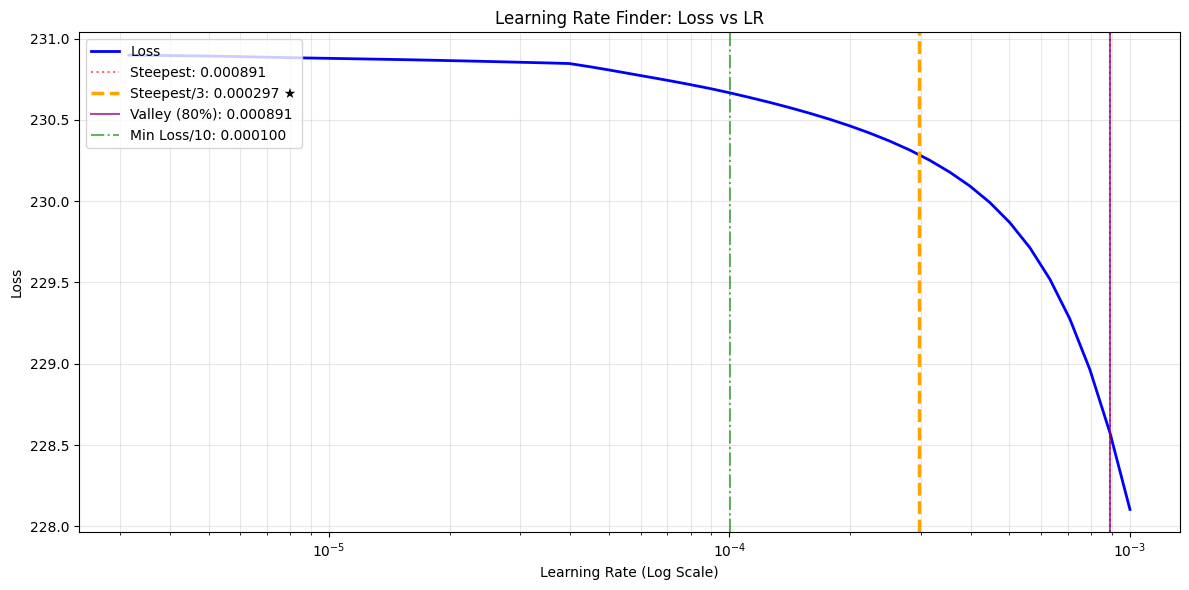

             LR FINDER RESULTS
  🔴 Steepest Gradient : 0.000891  (aggressive)
  🟠 Steepest / 3      : 0.000297  (balanced) ★ DEFAULT
  🟣 Valley (80%)      : 0.000891  (robust)
  🟢 Min Loss / 10     : 0.000100  (conservative)
  Selected Method: 'recommended' → LR = 0.000297

Optimal Learning Rate: 2.97e-04


In [10]:
# ═══════════════════════════════════════════════════════════════════════════════
# LRFINDER - FIND OPTIMAL LEARNING RATE
# ═══════════════════════════════════════════════════════════════════════════════
# Clone the model and run LRFinder to find optimal learning rate.
# The sampling function is now serializable, enabling model cloning.

import tensorflow as tf
from keras.optimizers import Adam
import keras.ops as ops  # Keras 3.0+ uses ops instead of backend

# Define reconstruction loss for LRFinder (same as VAE uses)
def vae_r_loss(y_true, y_pred):
    """Weighted reconstruction loss (MSE) for LRFinder."""
    return R_LOSS_FACTOR * ops.mean(ops.square(y_true - y_pred), axis=[1, 2, 3])

# Clone model for LRFinder
print("Cloning model for LRFinder...")
lr_model = tf.keras.models.clone_model(vae.model)
lr_model.compile(loss=vae_r_loss, optimizer=Adam(learning_rate=1e-6))
print("✓ Model cloned successfully")

# Run LRFinder
lr_finder = LRFinder(min_lr=1e-6, max_lr=1e-1, steps=100)
lr_model.fit(x_train, x_train, epochs=2, batch_size=BATCH_SIZE, callbacks=[lr_finder], verbose=0)

# Plot and get optimal LR
lr_finder.plot_loss()
OPTIMAL_LR = lr_finder.get_optimal_lr()
print(f"\nOptimal Learning Rate: {OPTIMAL_LR:.2e}")


In [11]:
# Initialize W&B with training configuration
run = init_wandb(
    name=f"vae_{DATASET_NAME}_{RUN_ID}",
    project="generative-deep-learning",
    config={
        "model": MODEL_TYPE,
        "dataset": DATASET_NAME,
        "learning_rate": OPTIMAL_LR,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "batch_size_source": "dynamic_finder",
        "model_params": vae.model.count_params(),
    }
)

wandb: Currently logged in as: cataluna84 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [12]:
# Compile VAE with learning rate and loss factor
vae.compile(OPTIMAL_LR, R_LOSS_FACTOR)

In [13]:
# ═══════════════════════════════════════════════════════════════════════════════
# TRAIN VAE
# ═══════════════════════════════════════════════════════════════════════════════

vae.train(
    x_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    run_folder=RUN_FOLDER,
    print_every_n_batches=PRINT_EVERY_N_BATCHES,
    initial_epoch=INITIAL_EPOCH,
    lr_decay=1,  # Disable internal scheduler to use external
    extra_callbacks=[
        WandbMetricsLogger(),
        LRLogger(),
        get_lr_scheduler(monitor='loss', patience=5),
        get_early_stopping(monitor='loss', patience=10),
    ]
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 225.2441 - vae_r_loss: 224.8406
Epoch 1: saving model to ../run/vae/0002_digits/weights/weights-001-210.61.weights.h5

Epoch 1: finished saving model to ../run/vae/0002_digits/weights/weights-001-210.61.weights.h5

Epoch 1: saving model to ../run/vae/0002_digits/weights/weights.weights.h5

Epoch 1: finished saving model to ../run/vae/0002_digits/weights/weights.weights.h5
Epoch 1: Learning Rate is 2.97e-04
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 239ms/step - loss: 210.6061 - vae_r_loss: 207.7963 - learning_rate: 2.9708e-04
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 111.5586 - vae_r_loss: 104.7380
Epoch 2: saving model to ../run/vae/0002_digits/weights/weights-002-94.49.weights.h5

Epoch 2: finished saving model to ../run/vae/0002_digits/weights/weights-002-94.49.weights.h5

Epoch 2: saving model to ../run/vae/0002_digits/weights/weights.weights.h5

Epoch 2: finished saving model to ../run/vae/0002_digits/weights/weigh

In [14]:
# Finalize W&B run
wandb.finish()

epoch/epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/vae_r_loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,99
epoch/learning_rate,0.0003
epoch/loss,47.41869
epoch/vae_r_loss,42.68276
learning_rate,0.0003


## Training Visualization

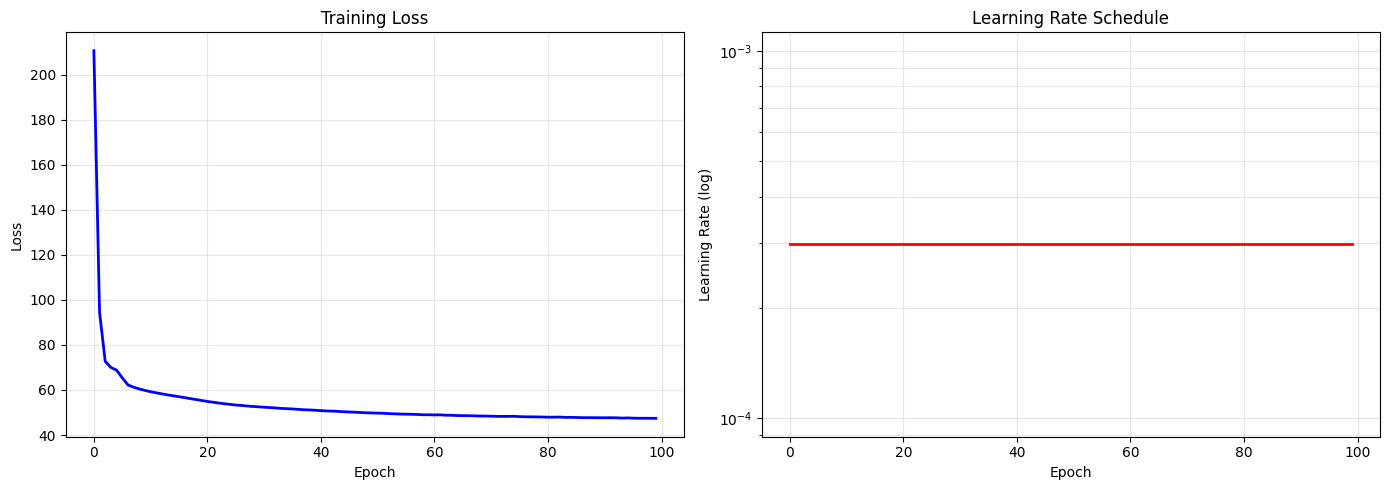


TRAINING SUMMARY
  Final Loss: 47.418686
  Min Loss  : 47.418686
  Epochs    : 100


In [15]:
# ═══════════════════════════════════════════════════════════════════════════════
# TRAINING VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════════

import matplotlib.pyplot as plt

if hasattr(vae, 'model') and hasattr(vae.model, 'history') and vae.model.history:
    history = vae.model.history.history
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss plot
    if 'loss' in history:
        axes[0].plot(history['loss'], 'b-', linewidth=2)
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training Loss')
        axes[0].grid(True, alpha=0.3)
    
    # LR plot (log scale)
    if 'learning_rate' in history:
        axes[1].semilogy(history['learning_rate'], 'r-', linewidth=2)
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Learning Rate (log)')
        axes[1].set_title('Learning Rate Schedule')
        axes[1].grid(True, which='both', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RUN_FOLDER, 'training_summary.png'), dpi=150)
    plt.show()
    
    print(f"\n{'='*50}")
    print("TRAINING SUMMARY")
    print(f"{'='*50}")
    print(f"  Final Loss: {history['loss'][-1]:.6f}")
    print(f"  Min Loss  : {min(history['loss']):.6f}")
    print(f"  Epochs    : {len(history['loss'])}")
    print(f"{'='*50}")
else:
    print("No training history available.")

# Cleanup: Restart Kernel to Release GPU Memory

In [16]:
# ═══════════════════════════════════════════════════════════════════════════════
# CLEANUP: Restart kernel to fully release GPU memory
# ═══════════════════════════════════════════════════════════════════════════════
# TensorFlow/CUDA does not release GPU memory within a running Python process.
# Restarting the kernel is the only guaranteed way to free all GPU resources.
# Run this cell only after all work is complete and saved.

# import IPython
# print("Restarting kernel to release GPU memory...")
# IPython.Application.instance().kernel.do_shutdown(restart=True)